<a href="https://colab.research.google.com/github/sayakpaul/A-B-testing-with-Machine-Learning/blob/master/Adversarial_Training_NSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [2]:
# Which GPU?
!nvidia-smi

Thu Apr  9 09:01:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# other imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

In [4]:
# Gather Flowers-17 dataset
data_root = tf.keras.utils.get_file(
  "/content/flower_photos", "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [0]:
# Untar the dataset
!tar -xvf flower_photos.tar.gz

In [0]:
# Tree for viewing directory structures
!sudo apt-get install tree

In [7]:
!tree --dirsfirst --filelimit 10 flower_photos

flower_photos
├── daisy [633 entries exceeds filelimit, not opening dir]
├── dandelion [898 entries exceeds filelimit, not opening dir]
├── roses [641 entries exceeds filelimit, not opening dir]
├── sunflowers [699 entries exceeds filelimit, not opening dir]
├── tulips [799 entries exceeds filelimit, not opening dir]
└── LICENSE.txt

5 directories, 1 file


In [8]:
# All the paths of the flowers
ALL_IMG_PATHS = list(paths.list_images("flower_photos"))
print(ALL_IMG_PATHS[:10])

['flower_photos/sunflowers/8192234807_fed4a46f1a_n.jpg', 'flower_photos/sunflowers/14741813110_94964c39e2_n.jpg', 'flower_photos/sunflowers/4806174512_e04475b766_n.jpg', 'flower_photos/sunflowers/19697910486_0086d893a2.jpg', 'flower_photos/sunflowers/3196753837_411b03682d_n.jpg', 'flower_photos/sunflowers/4816636411_0135bfe2c9_n.jpg', 'flower_photos/sunflowers/2694860538_b95d60122c_m.jpg', 'flower_photos/sunflowers/16988605969_570329ff20_n.jpg', 'flower_photos/sunflowers/14925398441_107f3e0304_n.jpg', 'flower_photos/sunflowers/5330608174_b49f7a4c48_m.jpg']


In [9]:
# shuffle the image paths and preview
random.shuffle(ALL_IMG_PATHS)
ALL_IMG_PATHS[:5]

['flower_photos/dandelion/3496258301_ca5f168306.jpg',
 'flower_photos/sunflowers/20753711039_0b11d24b50_n.jpg',
 'flower_photos/dandelion/2395009660_295c8ffd67_m.jpg',
 'flower_photos/roses/18584002386_cec0df537d_n.jpg',
 'flower_photos/dandelion/16744522344_8d21b1530d_n.jpg']

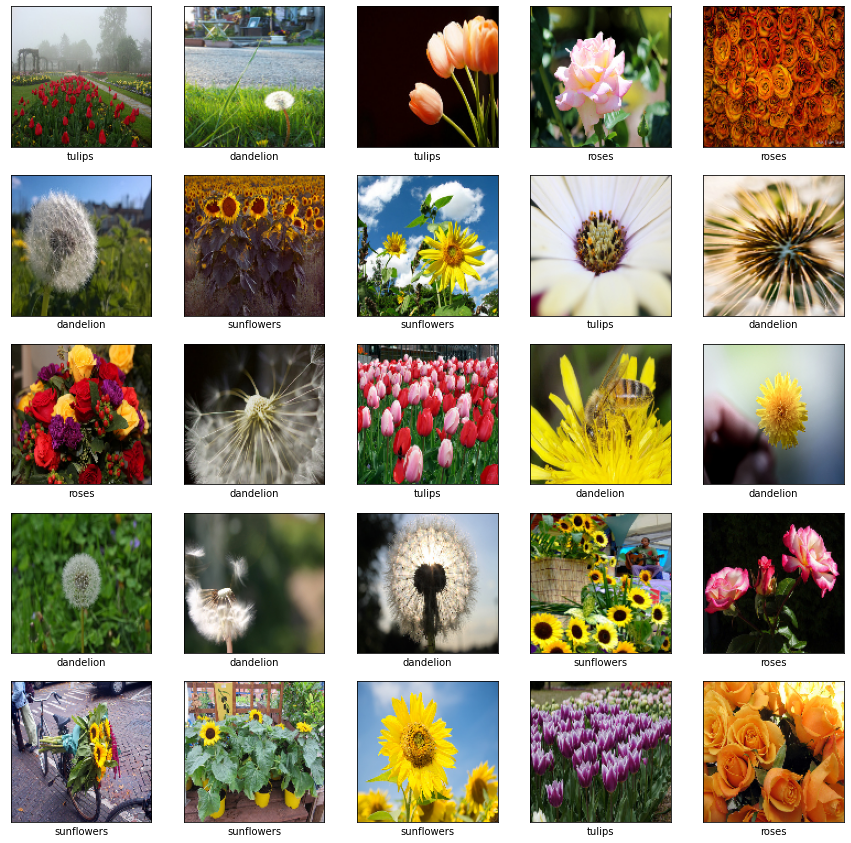

In [10]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(25):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

In [0]:
# going for a 0.15 test split
nb_test_images = int(len(list(paths.list_images("flower_photos"))) * 0.15)
nb_train_images = len(list(paths.list_images("flower_photos"))) - nb_test_images

In [0]:
# specify the directory paths
train_dir = "train"
val_dir = "val"

In [0]:
def move_images(nb_images, output_dir):
    # iterate through the number of images
    for i in tqdm(range(nb_images)):
        # grab an image path and grab the label of the image
        image_path = ALL_IMG_PATHS[i]
        # careful about the index of the split
        label = image_path.split("/")[1]
        
        # check if a directory for the label exists, if not create it
        new_image_dir = os.path.join(output_dir, label)
        if not os.path.exists(new_image_dir):
            os.makedirs(new_image_dir)
            
        # copy the current image to the respective folder
        shutil.copy2(image_path, new_image_dir)

In [14]:
# prepare the train and test set
move_images(nb_train_images, train_dir)
move_images(nb_test_images, val_dir)

100%|██████████| 550/550 [00:00<00:00, 4395.52it/s]


In [15]:
# Verify structures
!tree --dirsfirst --filelimit 10 train
!tree --dirsfirst --filelimit 10 val

train
├── daisy [533 entries exceeds filelimit, not opening dir]
├── dandelion [748 entries exceeds filelimit, not opening dir]
├── roses [556 entries exceeds filelimit, not opening dir]
├── sunflowers [598 entries exceeds filelimit, not opening dir]
└── tulips [685 entries exceeds filelimit, not opening dir]

5 directories, 0 files
val
├── daisy [103 entries exceeds filelimit, not opening dir]
├── dandelion [136 entries exceeds filelimit, not opening dir]
├── roses [102 entries exceeds filelimit, not opening dir]
├── sunflowers [103 entries exceeds filelimit, not opening dir]
└── tulips [106 entries exceeds filelimit, not opening dir]

5 directories, 0 files


In [16]:
# Setup data generators
train_aug = ImageDataGenerator(rescale=1/255.)
val_aug = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_directory("train",
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=32
)
val_gen = train_aug.flow_from_directory("val",
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=32
)

Found 3120 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [17]:
# Load the MobileNetv2 model but exclude the classification layers
EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
def get_training_model():
    # We are not training the extractor model
    EXTRACTOR.trainable = False
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

In [19]:
# Train the model
start = time.time()
model = get_training_model()
h = model.fit(train_gen,
              steps_per_epoch=3120//32,
              validation_data=val_gen,
              validation_steps=550//32,
              epochs=10)
print("Total training time: ",time.time()-start)

Epoch 1/10
97/97 [==============================] - 15s 150ms/step - loss: 0.6243 - accuracy: 0.7806 - val_loss: 0.2916 - val_accuracy: 0.9044
Epoch 2/10
97/97 [==============================] - 14s 142ms/step - loss: 0.3211 - accuracy: 0.8870 - val_loss: 0.2175 - val_accuracy: 0.9301
Epoch 3/10
97/97 [==============================] - 14s 143ms/step - loss: 0.2435 - accuracy: 0.9171 - val_loss: 0.1461 - val_accuracy: 0.9522
Epoch 4/10
97/97 [==============================] - 14s 142ms/step - loss: 0.2002 - accuracy: 0.9258 - val_loss: 0.1037 - val_accuracy: 0.9688
Epoch 5/10
97/97 [==============================] - 14s 142ms/step - loss: 0.1447 - accuracy: 0.9524 - val_loss: 0.0979 - val_accuracy: 0.9743
Epoch 6/10
97/97 [==============================] - 14s 141ms/step - loss: 0.1329 - accuracy: 0.9521 - val_loss: 0.0670 - val_accuracy: 0.9798
Epoch 7/10
97/97 [==============================] - 14s 140ms/step - loss: 0.0920 - accuracy: 0.9660 - val_loss: 0.0348 - val_accuracy: 0.9945

In [0]:
# Specify the class labels, we would need this to create targeted attacks
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [52]:
# Let's take an image from the validation set randomly
all_val_imgs = list(paths.list_images("val"))
sample_val_image = np.random.choice(all_val_imgs, 1)[0]
sample_val_image

'val/tulips/8713389178_66bceb71a8_n.jpg'

In [0]:
# A utility function for sample predictions
def generate_predictions(model, image_path):
    # Prepare the image for prediction-ready
    original_label = image_path.split("/")[1]
    image_pixels = plt.imread(image_path)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = image_pixels/255.
    image_pixels = np.expand_dims(image_pixels, axis=0)

    # Generate predictions
    preds = model.predict(image_pixels)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Original label: {} predicted label: {}".format(original_label, pred_label))

    return preds

In [54]:
# Let's see
preds = generate_predictions(model, sample_val_image)

Original label: tulips predicted label: tulips


In [56]:
# Loss has to be very low here
cce = tf.keras.losses.SparseCategoricalCrossentropy()
loss = cce(
    tf.convert_to_tensor([4]),
    tf.convert_to_tensor(preds)
)
print(loss.numpy())

# The probability we got when we ran the inference
print(np.exp(-loss.numpy()))

8.070143e-05
0.9999193


In [0]:
# We won't need normalization for now
def preprocess_image_without(image_path):
    image_pixels = plt.imread(image_path)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

In [0]:
# Clipping utility so that the pixel values stay within [0,1]
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [0]:
def generate_adversaries_targeted(model, image_tensor, delta, 
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = (image_tensor + delta)/255.
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [0]:
def perturb_image(model, image_path, true, target):
    print("Before adversaries")
    _ = generate_predictions(model, sample_val_image)
    
    # Initialize the perturbation quantity
    preprocessed_image = preprocess_image_without(sample_val_image)
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(model, image_tensor, delta, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = (image_tensor + delta_tensor)/255.
    print("After adversaries")
    
    # Generate predictions
    preds = model.predict(perturbed_image)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Predicted label: {}".format(pred_label))

Before adversaries
Original label: tulips predicted label: tulips
0 16.118015
20 16.112925
40 14.983172
60 9.786907
80 6.645723
100 4.6251664
120 3.1495295
140 1.8325343
160 0.7661972
180 0.014573097
200 -0.65887856
220 -1.2820206
240 -1.911403
260 -2.5374045
280 -3.1360862
300 -3.611886
320 -4.032117
340 -4.436274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


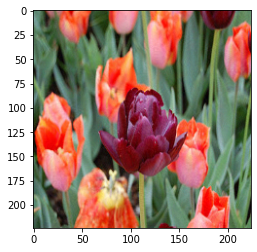

After adversaries
Predicted label: dandelion


In [61]:
# Let's see this in action
perturb_image(model, sample_val_image, 4, 1)